# Analyzing GRB 091816C
To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

In [48]:
# Scientific libraries
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context='notebook', fscale=1, ticks=True, grid=False)
plt.style.use('mike')

from threeML import *

import warnings
warnings.simplefilter('ignore')

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [49]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

Building cache for fermigbrst.



name,ra,dec,trigger_time,t90
object,float64,float64,float64,float64
GRB080916009,119.800,-56.600,54725.0088613,62.977


To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [50]:
grb_info =  gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info['detectors']
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model =  gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [51]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                 value min_value max_value            unit
GRB080916009...K             0.0122548         0      None  keV-1 s-1 cm-2
GRB080916009...alpha          -1.13042      -1.5         2                
GRB080916009...break_energy    309.203        10      None             keV
GRB080916009...break_scale         0.3         0        10                
GRB080916009...beta           -2.09693        -5      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database. 



In [52]:
dload = download_GBM_trigger_data("bn080916009",detectors=gbm_detectors)

Let's first examine the catalof fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background. 
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Auto-determined polynomial order: 0




Binned 0-order polynomial fit with the Powell method



Saved fitted background to n3_bkg.h5.

Successfully restored fit from n3_bkg.h5


<IPython.core.display.Javascript object>


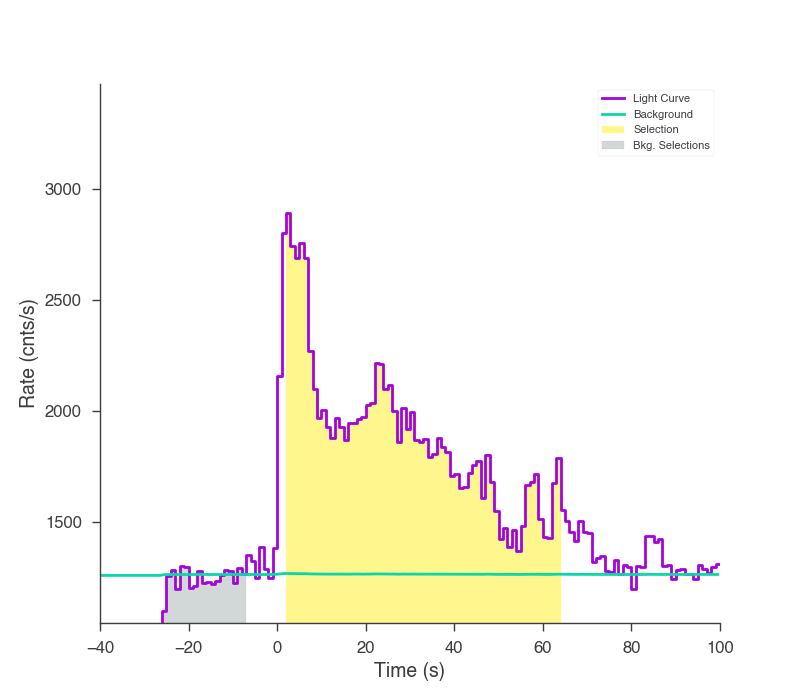

Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 9-900 translates to channels 5-124
Now using 120 channels out of 128
Now using 120 bins


Auto-determined polynomial order: 1




Binned 1-order polynomial fit with the Powell method



Saved fitted background to n4_bkg.h5.

Successfully restored fit from n4_bkg.h5


<IPython.core.display.Javascript object>


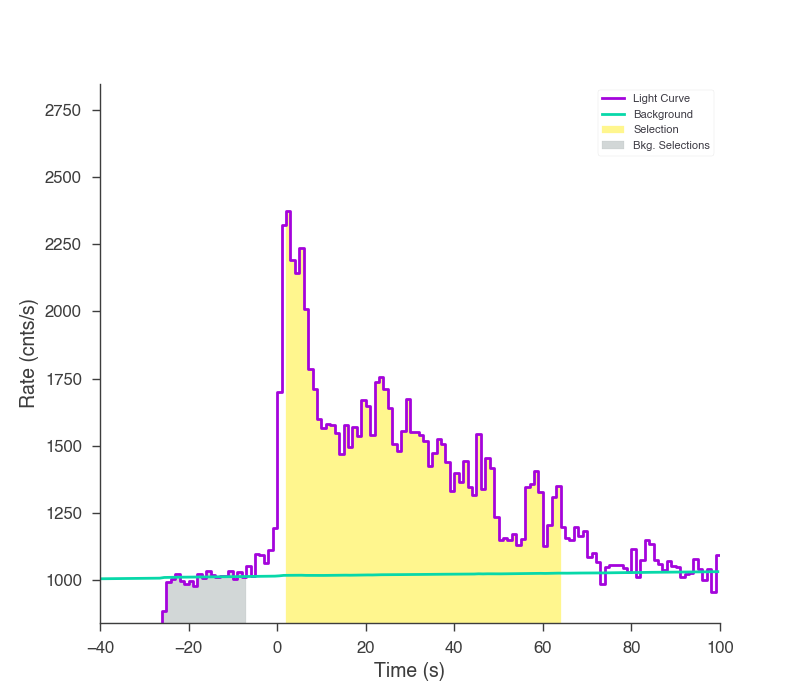

Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 9-900 translates to channels 5-123
Now using 119 channels out of 128
Now using 119 bins


Auto-determined polynomial order: 1




Binned 1-order polynomial fit with the Powell method



Saved fitted background to b0_bkg.h5.

Successfully restored fit from b0_bkg.h5


<IPython.core.display.Javascript object>


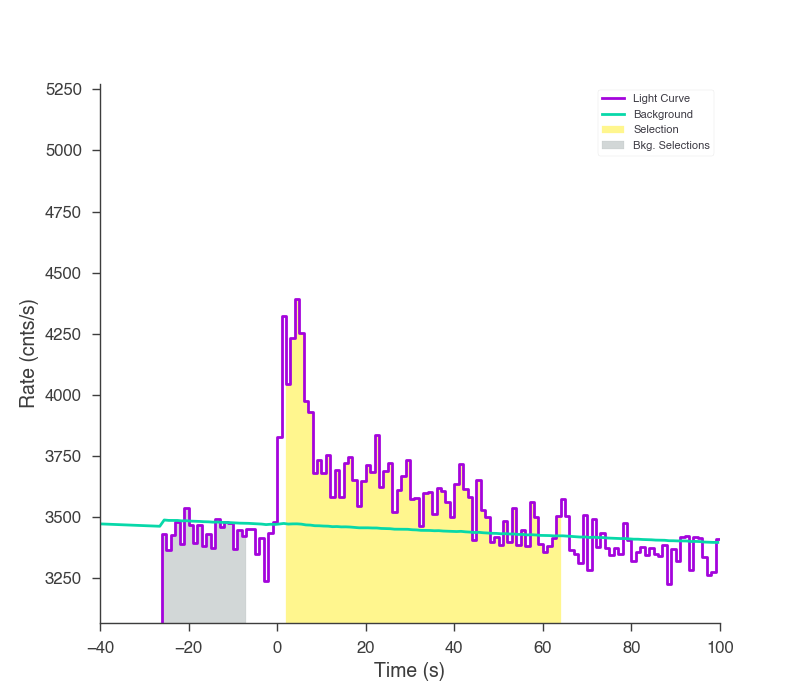

Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 250-30000 translates to channels 1-119
Now using 119 channels out of 128
Now using 119 bins


In [53]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:

    
    
    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )
    
    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)
    
    fluence_plugin = ts_tte.to_spectrumlike()
    
    if det.startswith("b"):
        
        fluence_plugin.set_active_measurements("250-30000")
    
    else:
        
        fluence_plugin.set_active_measurements("9-900")
    
    fluence_plugin.rebin_on_background(1.)
    
    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog. 

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters. 


In [54]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(lower_bound = -1.5, upper_bound = 1, mu=-1, sigma=0.5)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(lower_bound = -5, upper_bound = -1.6, mu=-2.25, sigma=0.5)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(lower_bound = 1E-3, upper_bound = 1E1)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(lower_bound = 1E-4, upper_bound = 10)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest. 

In [55]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))
bayes.set_sampler("multinest")


### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.  

<IPython.core.display.Javascript object>


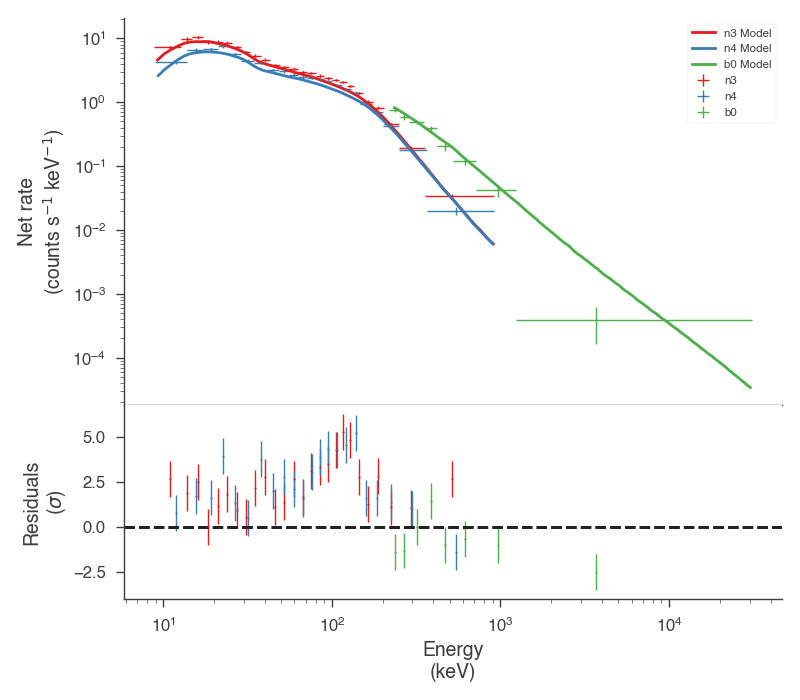

In [57]:
display_spectrum_model_counts(bayes, min_rate=20, step=False );

### Run the sampler
We let MultiNest condition the model on the data

In [58]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
GRB080916009...K,(1.470 +/- 0.018) x 10^-2,1 / (cm2 keV s)
GRB080916009...alpha,-1.072 +/- 0.016,
GRB080916009...break_energy,(2.24 +/- 0.23) x 10^2,keV
GRB080916009...break_scale,(2.1 -0.6 +0.7) x 10^-1,
GRB080916009...beta,-2.16 +/- 0.08,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0,-1072.777786
n3,-1024.018959
n4,-1013.981633
total,-3110.778378



Values of statistical measures:



,statistical measures
AIC,6231.727211
BIC,6250.959422
DIC,6218.515304
PDIC,4.245499
log(Z),-1357.260177


Now our model seems to match much better with the data! 

<IPython.core.display.Javascript object>


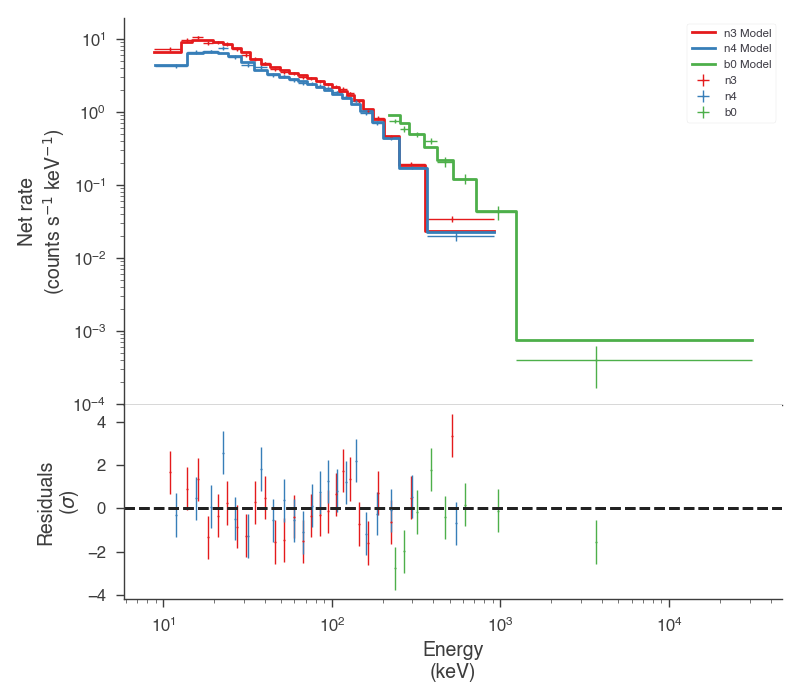

In [61]:
bayes.restore_median_fit()
display_spectrum_model_counts(bayes, min_rate=20);

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [77]:
conversion = u.Unit('keV2/(cm2 s keV)').to('erg2/(cm2 s keV)')
energy_grid = np.logspace(1,4, 100)*u.keV
vFv = (energy_grid**2* model.get_point_source_fluxes(0, energy_grid)).to('erg2/(cm2 s keV)')



<IPython.core.display.Javascript object>


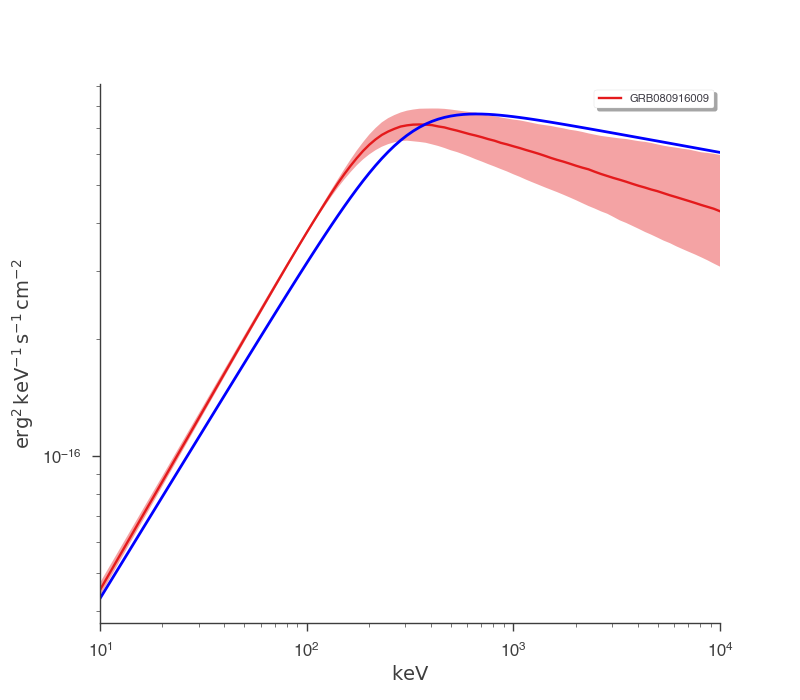

In [81]:
fig = plot_point_source_spectra(bayes.results, flux_unit='erg2/(cm2 s keV)');
ax = fig.get_axes()[0]
ax.loglog(energy_grid, vFv, color='blue', label='catalog model')

## Time Resolved Analysis 

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series['n3']

In [17]:
n3.create_time_bins(0,60, method="bayesblocks", use_background=True, p0=0.2)

Created 15 bins via bayesblocks


Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<IPython.core.display.Javascript object>


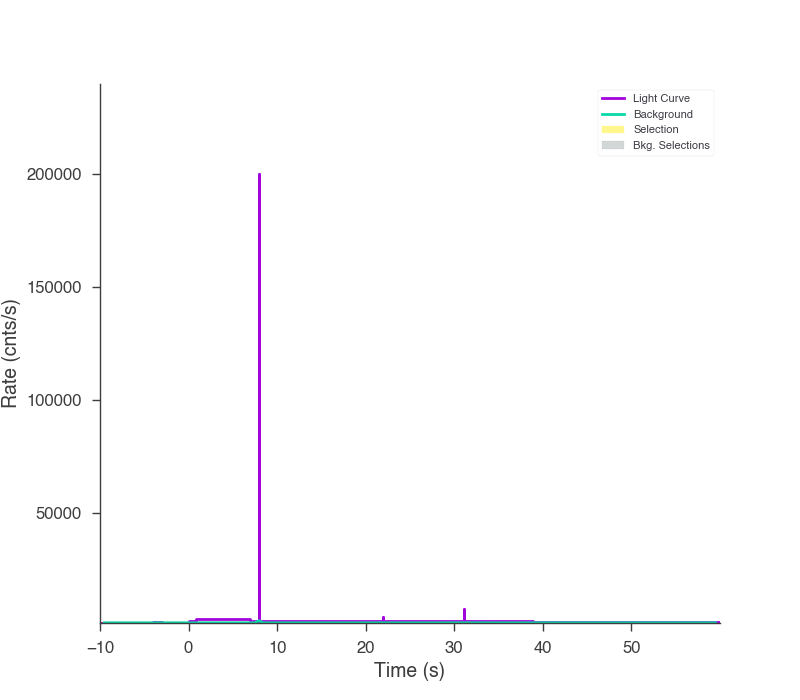

In [18]:
n3.view_lightcurve(use_binner=True);

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):
    
    if w < 5E-2:
        bad_bins.append(i)
    
    
edges = [n3.bins.starts[0]]

for i,b in enumerate(n3.bins):
    
    if i not in bad_bins:        
        edges.append(b.stop)

starts=edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method='custom')

Created 12 bins via custom


Now our light curve looks much more acceptable.

<IPython.core.display.Javascript object>


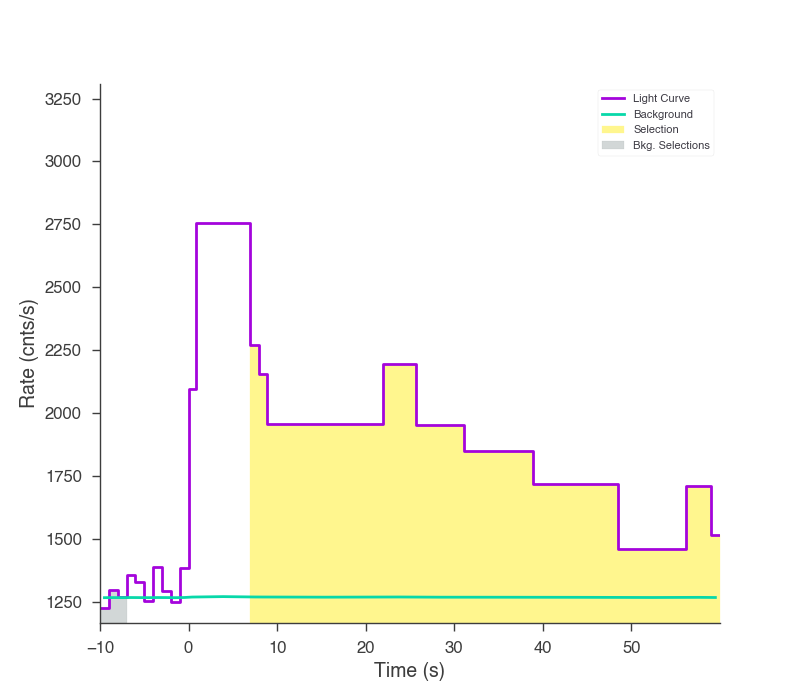

In [21]:
n3.view_lightcurve(use_binner=True);

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above. 

In [37]:
time_resolved_plugins = {}

for k,v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

Created 12 bins via custom


Created 12 bins via custom


Created 12 bins via custom


### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [38]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound = -1.5, upper_bound = 1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound = -5, upper_bound = -1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (0, None)
band.K.prior = Log_uniform_prior(lower_bound=1E-10, upper_bound=1E3)
ps = PointSource('grb', 0,0, spectral_shape=band)
band_model = Model(ps)



### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [39]:
models = []
results = []
analysis = []
for interval in range(12):

    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():

        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)
    bayes.set_sampler("multinest")
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.6 +/- 0.6) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-5.5 +/- 1.3) x 10^-1,
grb.spectrum.main.Band.xp,(3.4 +/- 0.7) x 10^2,keV
grb.spectrum.main.Band.beta,-2.28 -0.29 +0.28,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval0,-284.063915
n3_interval0,-244.898129
n4_interval0,-262.626427
total,-791.588472



Values of statistical measures:



,statistical measures
AIC,1591.290258
BIC,1606.699076
DIC,1569.863549
PDIC,2.363414
log(Z),-344.771139


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(4.20 -0.14 +0.15) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.48 -0.25 +0.32) x 10^-1,
grb.spectrum.main.Band.xp,(5.9 -0.5 +0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-2.19 +/- 0.04,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval1,-677.736086
n3_interval1,-634.714426
n4_interval1,-638.007585
total,-1950.458098



Values of statistical measures:



,statistical measures
AIC,3909.029510
BIC,3924.438327
DIC,3882.511307
PDIC,2.700899
log(Z),-850.587671


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.81 -0.15 +0.13) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.03 +/- 0.05,
grb.spectrum.main.Band.xp,(5.1 +/- 0.8) x 10^2,keV
grb.spectrum.main.Band.beta,-2.24 -0.11 +0.08,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval2,-320.977750
n3_interval2,-282.498411
n4_interval2,-306.229701
total,-909.705862



Values of statistical measures:



,statistical measures
AIC,1827.525038
BIC,1842.933855
DIC,1801.205731
PDIC,0.939649
log(Z),-396.999362


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.1 +/- 0.4) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.9 +/- 0.8) x 10^-1,
grb.spectrum.main.Band.xp,(3.1 +/- 0.5) x 10^2,keV
grb.spectrum.main.Band.beta,-2.24 -0.26 +0.25,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval3,-296.527081
n3_interval3,-237.454927
n4_interval3,-257.339647
total,-791.321655



Values of statistical measures:



,statistical measures
AIC,1590.756624
BIC,1606.165442
DIC,1569.118312
PDIC,2.667870
log(Z),-345.068420


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.05 +/- 0.09) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.77 -0.33 +0.34) x 10^-1,
grb.spectrum.main.Band.xp,(4.0 +/- 0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-2.17 -0.16 +0.15,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval4,-791.589887
n3_interval4,-751.757548
n4_interval4,-741.054135
total,-2284.401570



Values of statistical measures:



,statistical measures
AIC,4576.916455
BIC,4592.325273
DIC,4556.528962
PDIC,3.241615
log(Z),-995.117792


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.02 -0.17 +0.18) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.5 -0.4 +0.5) x 10^-1,
grb.spectrum.main.Band.xp,(3.64 -0.34 +0.30) x 10^2,keV
grb.spectrum.main.Band.beta,-2.12 -0.07 +0.12,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval5,-541.641966
n3_interval5,-518.326497
n4_interval5,-521.396171
total,-1581.364635



Values of statistical measures:



,statistical measures
AIC,3170.842584
BIC,3186.251401
DIC,3151.095758
PDIC,3.584572
log(Z),-689.756733


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.98 +/- 0.12) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-10.0 -0.5 +0.4) x 10^-1,
grb.spectrum.main.Band.xp,(4.3 +/- 0.5) x 10^2,keV
grb.spectrum.main.Band.beta,-2.66 -0.28 +0.27,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval6,-611.408977
n3_interval6,-578.631273
n4_interval6,-571.133114
total,-1761.173364



Values of statistical measures:



,statistical measures
AIC,3530.460043
BIC,3545.868861
DIC,3506.537221
PDIC,2.891525
log(Z),-766.599850


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.73 +/- 0.10) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.02 -0.04 +0.05,
grb.spectrum.main.Band.xp,(3.9 -0.4 +0.5) x 10^2,keV
grb.spectrum.main.Band.beta,-2.25 +/- 0.09,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval7,-670.373842
n3_interval7,-635.287906
n4_interval7,-644.436178
total,-1950.097926



Values of statistical measures:



,statistical measures
AIC,3908.309167
BIC,3923.717984
DIC,3886.620716
PDIC,2.537980
log(Z),-849.734951


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.58 +/- 0.12) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.2 +/- 0.6) x 10^-1,
grb.spectrum.main.Band.xp,(3.6 +/- 0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-2.57 -0.28 +0.29,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval8,-705.786638
n3_interval8,-693.183869
n4_interval8,-661.280187
total,-2060.250695



Values of statistical measures:



,statistical measures
AIC,4128.614704
BIC,4144.023522
DIC,4107.482267
PDIC,3.061377
log(Z),-896.928597


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.1 +/- 0.4) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.8 -2.1 +2.2) x 10^-1,
grb.spectrum.main.Band.xp,(1.4 +/- 0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-2.13 -0.24 +0.25,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval9,-654.848033
n3_interval9,-615.034589
n4_interval9,-614.015306
total,-1883.897928



Values of statistical measures:



,statistical measures
AIC,3775.909171
BIC,3791.317989
DIC,3757.033321
PDIC,-4.402624
log(Z),-820.433502


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.20 -0.4 +0.32) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-7.1 -1.2 +1.0) x 10^-1,
grb.spectrum.main.Band.xp,(2.2 +/- 0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-2.15 -0.21 +0.23,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval10,-461.323189
n3_interval10,-433.765498
n4_interval10,-429.689767
total,-1324.778453



Values of statistical measures:



,statistical measures
AIC,2657.670220
BIC,2673.079038
DIC,2638.397603
PDIC,1.714610
log(Z),-577.170091


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(5.2 -3.3 +2.9) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-3 -5 +4) x 10^-1,
grb.spectrum.main.Band.xp,(1.03 -0.25 +0.21) x 10^2,keV
grb.spectrum.main.Band.beta,-2.10 -0.28 +0.32,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval11,-292.344685
n3_interval11,-269.151005
n4_interval11,-253.502109
total,-814.997798



Values of statistical measures:



,statistical measures
AIC,1638.108911
BIC,1653.517729
DIC,1609.288003
PDIC,-10.393477
log(Z),-355.409434


### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

<IPython.core.display.Javascript object>


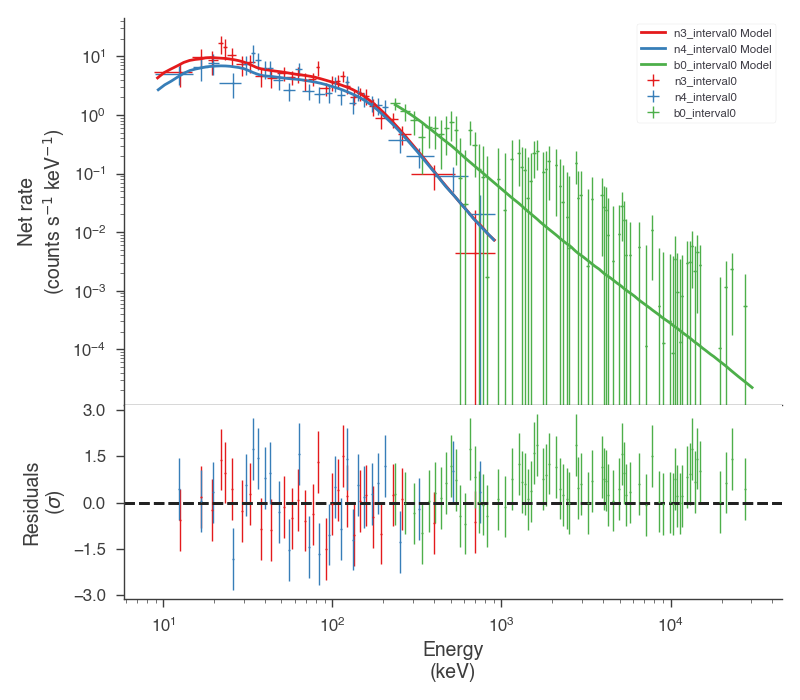

<IPython.core.display.Javascript object>


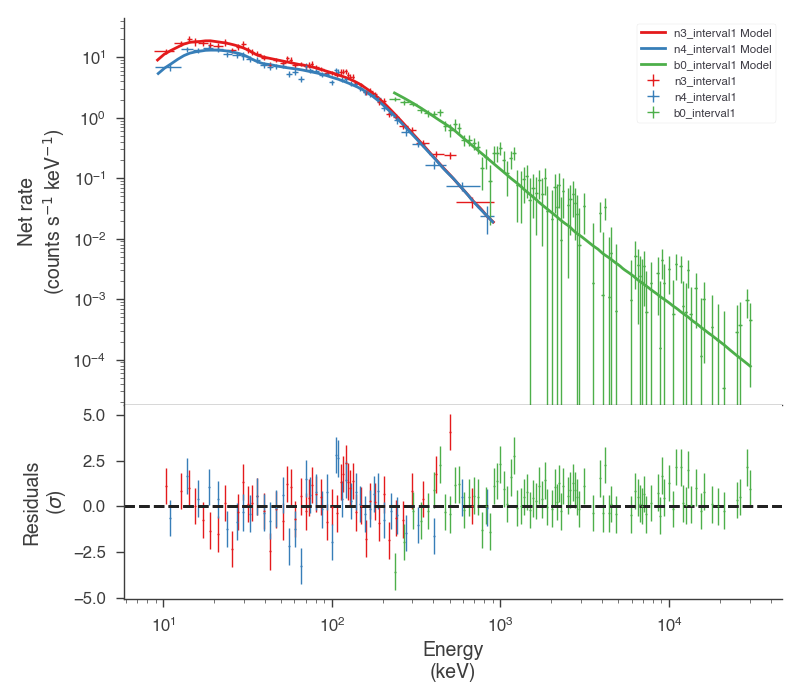

<IPython.core.display.Javascript object>


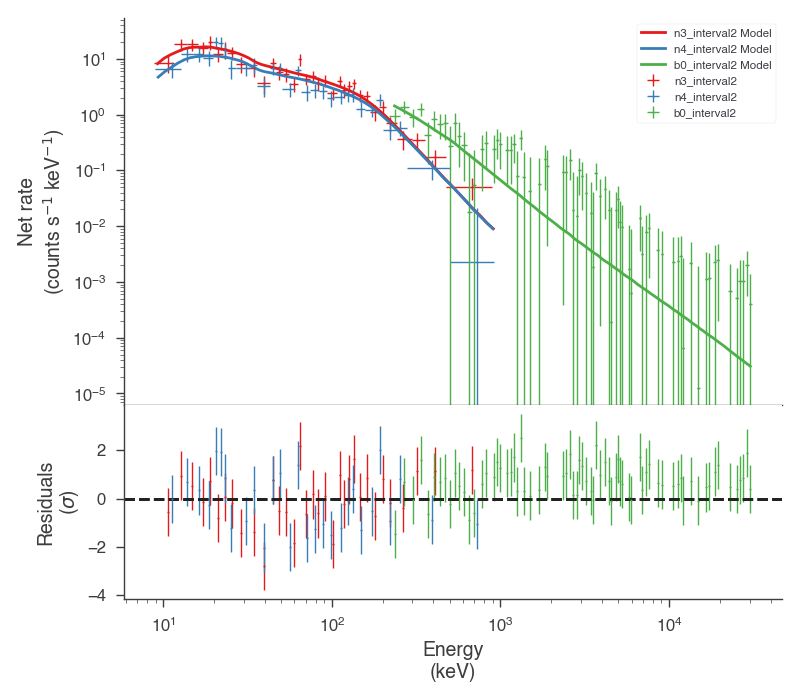

<IPython.core.display.Javascript object>


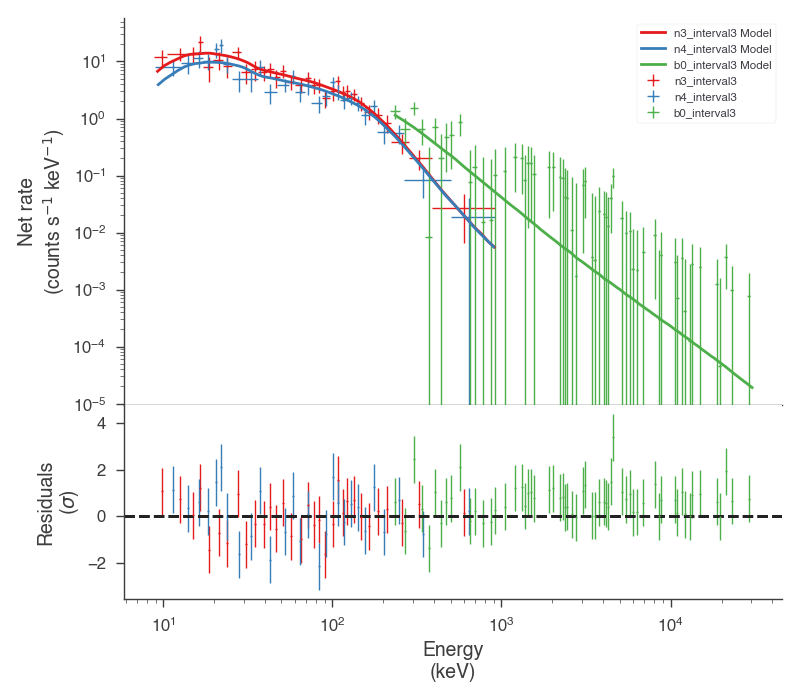

<IPython.core.display.Javascript object>


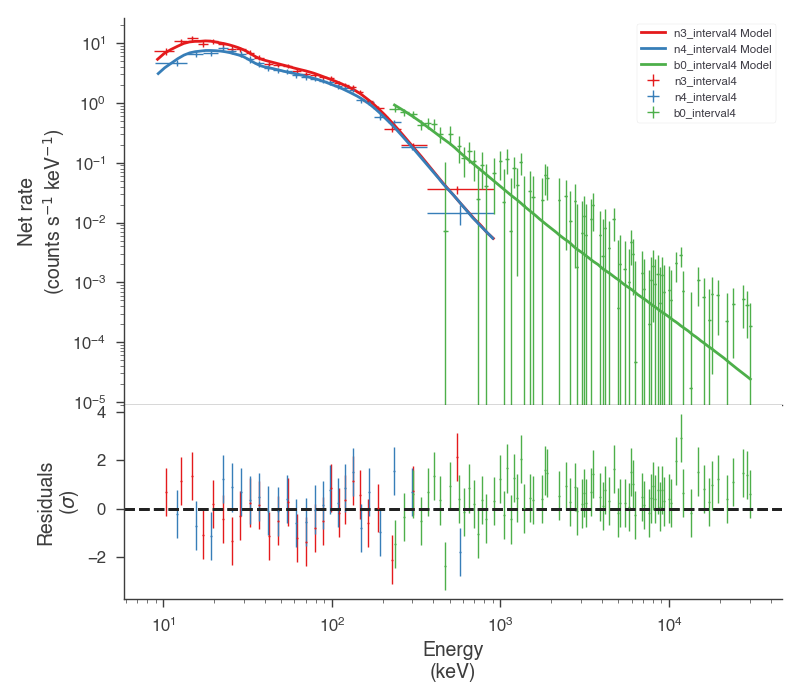

<IPython.core.display.Javascript object>


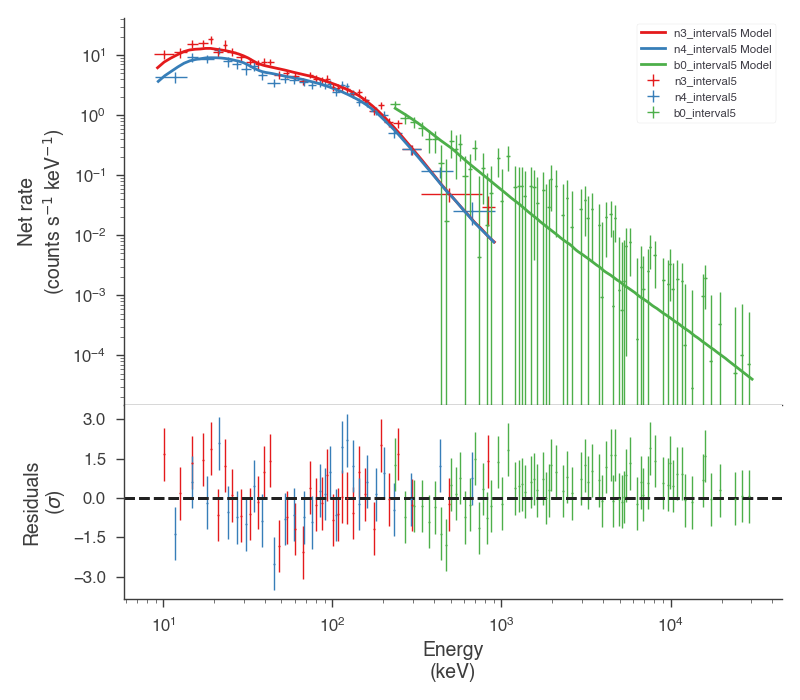

<IPython.core.display.Javascript object>


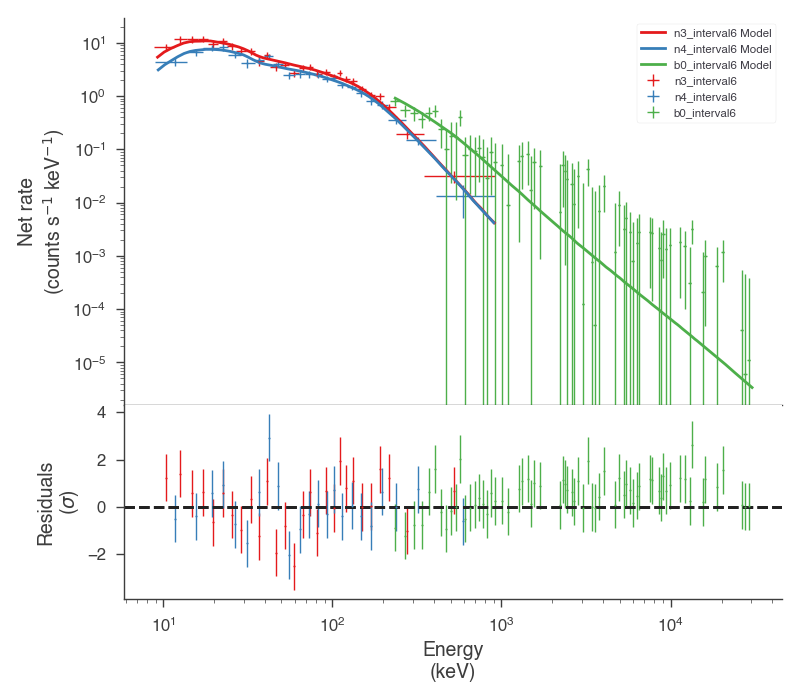

<IPython.core.display.Javascript object>


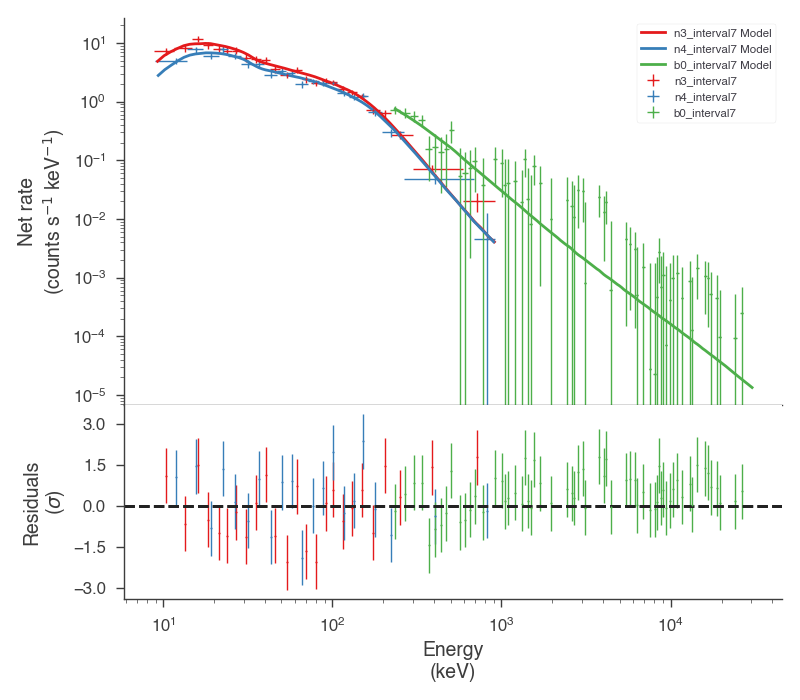

<IPython.core.display.Javascript object>


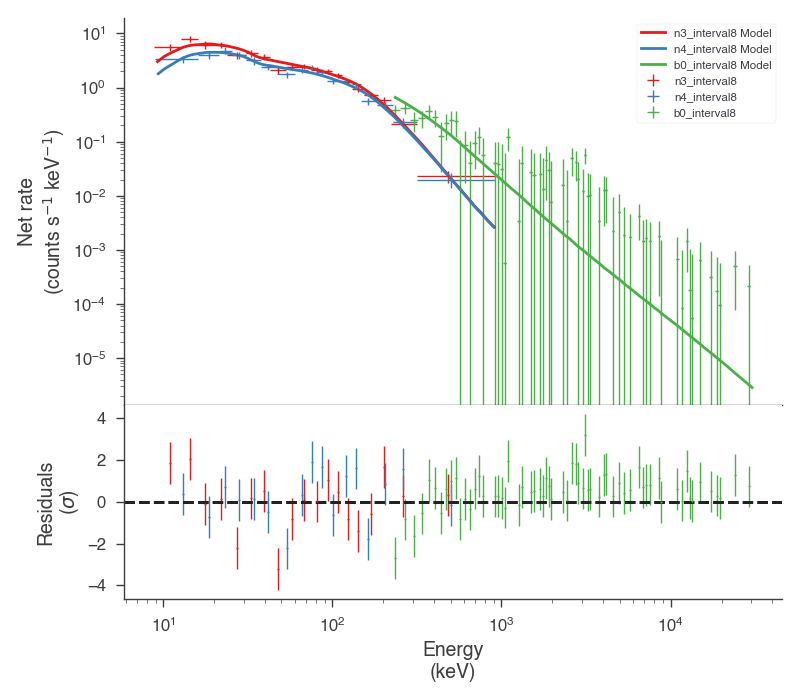

<IPython.core.display.Javascript object>


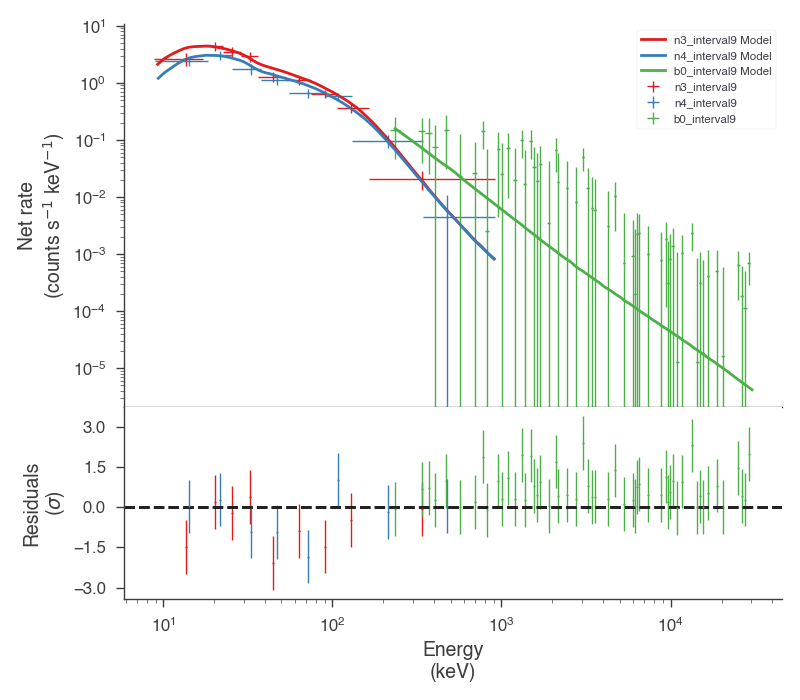

<IPython.core.display.Javascript object>


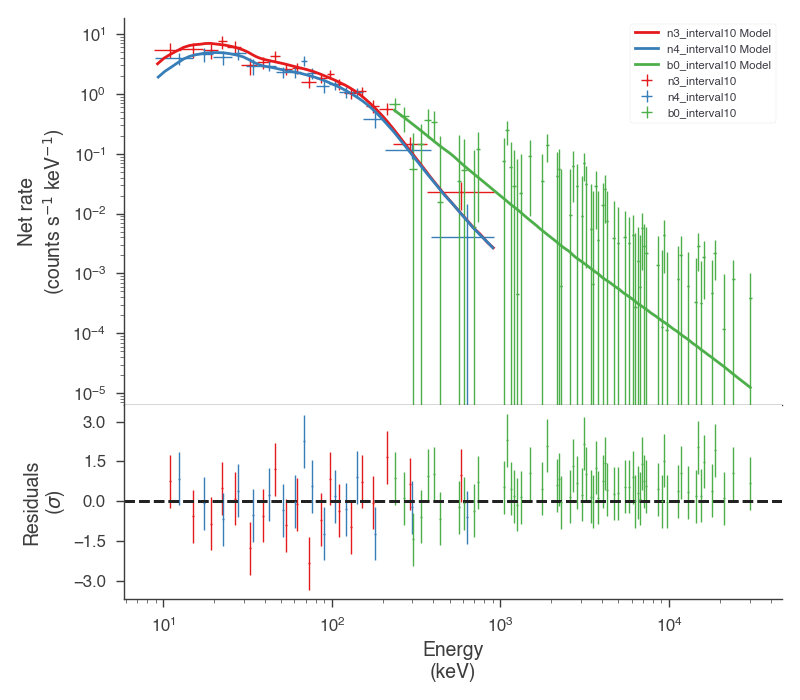

<IPython.core.display.Javascript object>


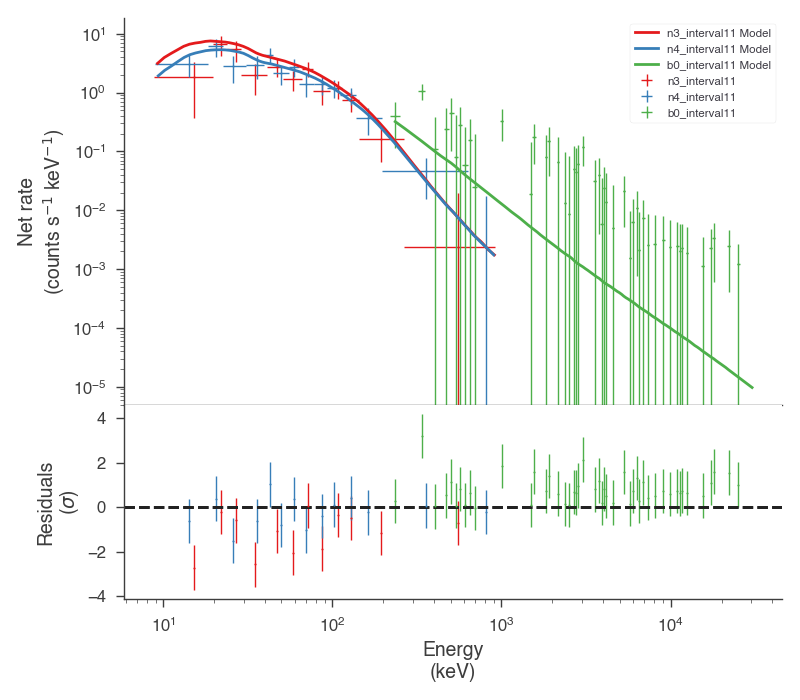

In [40]:
for a in analysis:
    a.restore_median_fit()
    display_spectrum_model_counts(a, min_rate=[20,20,-99], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

<IPython.core.display.Javascript object>


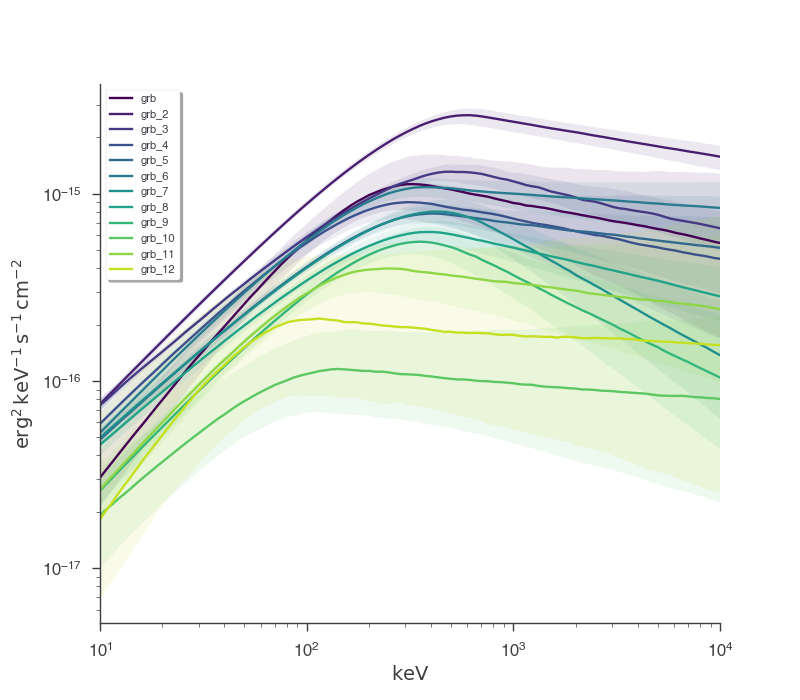

In [47]:
plot_spectra(*[a.results for a in analysis[::1]], flux_unit="erg2/(cm2 s keV)", fit_cmap='viridis', contour_cmap='viridis', contour_style_kwargs=dict(alpha=0.1));

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data. 